In [16]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import splprep, splev
from scipy.ndimage import gaussian_filter1d 
import numpy as np

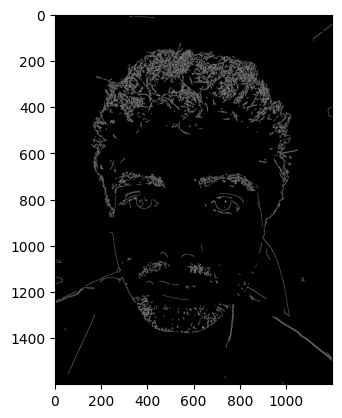

In [17]:
edge_detector = cv2.Canny
img = cv2.imread("faceimages/krrish.jpeg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
edges = edge_detector(img , 100, 200)
plt.imshow(edges, cmap='gray')

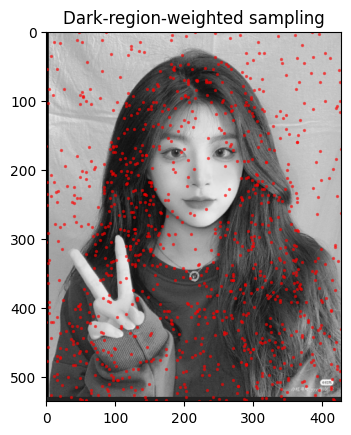

In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load and convert image to grayscale
image = Image.open("faceimages/cutegirl.png").convert("L")
img = np.array(image, dtype=np.float32)

# Invert brightness so dark regions have higher weights
weights = 255 - img
weights += 1e-8
probs = weights.flatten() / weights.sum()

# Sample points
N = 1000
indices = np.random.choice(len(probs), size=N, p=probs)
ys, xs = np.divmod(indices, img.shape[1])

# Visualize
plt.imshow(img, cmap='gray')
plt.scatter(xs, ys, s=2, c='red', alpha=0.5)
plt.title("Dark-region-weighted sampling")
plt.show()


Extracted edges from faceimages/cutegirl.png


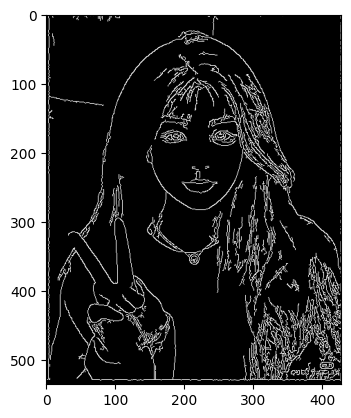

In [19]:

def extract_edges(image_path, min_threshold=200, max_threshold=200):
    """
    Function 1: Load image and extract edges using OpenCV Canny
    
    Returns:
        gray: Grayscale image
        edges: Binary edge map
    """
    gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(gray, min_threshold, max_threshold)
    
    print(f"Extracted edges from {image_path}")
    return gray, edges

gray, edges = extract_edges("faceimages/cutegirl.png", 50, 200)
edges = np.where(edges > 0, 1, 0)  # Convert to binary 0/1 array
plt.imshow(edges, cmap='gray')



Ordering 2000 edge points...
Ordered 2000 points.
[[166 477]
 [167 475]
 [165 475]
 ...
 [343 204]
 [347 214]
 [350 219]]


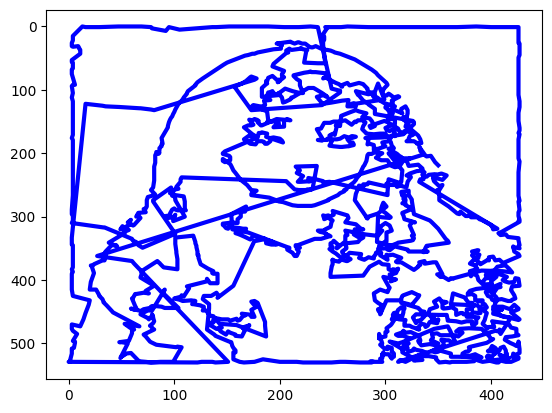

In [20]:


def order_edge_points(edges, n_samples=5000, ord=3):
    """
    Function 2: Extract edge points and order them using nearest neighbor
    
    Returns:
        ordered_points: Nx2 array of ordered (x, y) coordinates
    """
    # Get edge coordinates
    y_coords, x_coords = np.where(edges > 0)
    all_points = np.column_stack((x_coords, y_coords))      #stacking them along column
    
    # Sample if too many points
    if len(all_points) > n_samples:
        indices = np.random.choice(len(all_points), n_samples, replace=False)
        points = all_points[indices]
    else:
        points = all_points
    
    print(f"Ordering {len(points)} edge points...")
    
    # Order points using nearest neighbor
    current = 0
    visited = {current}
    ordered_points = [points[current]]
    
    while len(visited) < len(points):
        current_point = points[current]
        distances = np.linalg.norm(points - current_point,  ord=ord,axis=1)
        distances[list(visited)] = np.inf
        
        next_idx = np.argmin(distances)
        if distances[next_idx] == np.inf:
            break
            
        ordered_points.append(points[next_idx])
        visited.add(next_idx)
        current = next_idx
    
    ordered_points = np.array(ordered_points)
    # ordered_points = ordered_points - np.mean(ordered_points, axis=0)
    # ordered_points = ordered_points / np.max(np.linalg.norm(ordered_points, axis=1))

    return ordered_points


ordered_points = order_edge_points(edges, n_samples=2000, ord=2)
print(f"Ordered {len(ordered_points)} points.")
plt.plot(ordered_points[:, 0], ordered_points[:, 1], 'b-', linewidth=3)
plt.gca().invert_yaxis() 

print(ordered_points)


In [21]:
def create_smooth_spline(ordered_points,  smoothing_factor=0.4):
    """
    Function 3: Create smooth spline curve from ordered points
    
    Returns:
        smooth_curve: Mx2 array of smooth curve points
    """
    try:
        #fitting a parametric spline to the ordered points
        tck, u = splprep([ordered_points[:, 0], ordered_points[:, 1]], 
                        s=smoothing_factor * len(ordered_points), 
                        per=True)
        
        #this is sampling it uniformly in time 0 to 1
        u_new = np.linspace(0, 1, len(ordered_points)*2)
        smooth_x, smooth_y = splev(u_new, tck)
        smooth_curve = np.column_stack((smooth_x, smooth_y))

    except:
        print("Spline failed, using Gaussian smoothing")
        smooth_x = gaussian_filter1d(ordered_points[:, 0], sigma=1.0, mode='wrap')
        smooth_y = gaussian_filter1d(ordered_points[:, 1], sigma=1.0, mode='wrap')
        smooth_curve = np.column_stack((smooth_x, smooth_y))

    return smooth_curve



In [22]:
smooth_curve= create_smooth_spline(ordered_points)

In [23]:
smooth_curve = smooth_curve - np.mean(smooth_curve, axis=0)
smooth_curve = smooth_curve / np.max(np.linalg.norm(smooth_curve, axis=1))


In [24]:


def fourier_approximate(smooth_curve, n_frequencies=900):


    """
    Function 4: Approximate smooth curve using Fourier series
    
    Returns:
        frequencies: Integer frequencies for epicycles
        magnitude: Circle radii (amplitudes)
        phases: Starting angles
    """
    # Create complex signal
    z = smooth_curve[:,0] + 1j * smooth_curve[:,1]
    N = len(z)
    
    # Compute FFT and frequencies
    coefficients = np.fft.fft(z , norm='forward')
    frequencies = np.fft.fftfreq(N, 1/N)  # integer frequencies
    
    # Keep n largest components
    indices = np.argsort(-np.abs(coefficients))[:n_frequencies]
    frequencies = frequencies[indices]
    coefficients = coefficients[indices]
    
    # Get amplitudes and phases
    magnitude = np.abs(coefficients)
    phases = np.angle(coefficients)
    
    return frequencies, magnitude, phases

frequencies, magnitude, phases = fourier_approximate(smooth_curve, n_frequencies=1000)
print(frequencies[-10:], magnitude[-10:], phases[-10:])
print(frequencies.shape, magnitude.shape, phases.shape)


[ 510.  642. -664.  483. -300.  534.  522.  620.  735.  431.] [0.00013678 0.00013678 0.00013583 0.00013578 0.00013534 0.00013505
 0.00013504 0.00013491 0.00013491 0.00013491] [ 0.92933326  1.22648965 -1.24574276  1.87515581 -0.19809384 -2.26834478
 -0.49458702 -0.24274064  0.54253501 -1.87955818]
(1000,) (1000,) (1000,)


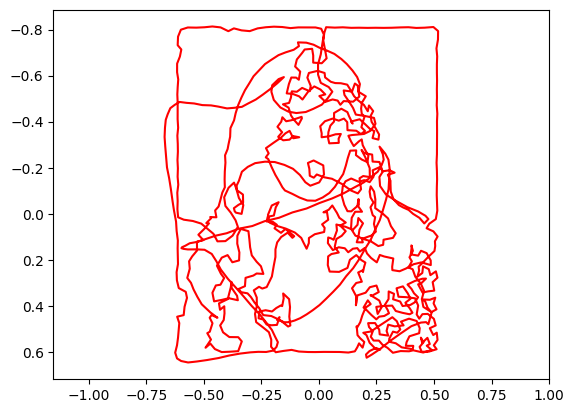

In [25]:
N = 1000
t_values = np.linspace(0, 1, N)  # Normalized time from 0 to 1

path = []
for t in t_values:
    z = 0
    for freq, amp, phase in zip(frequencies, magnitude, phases):
        z += amp * np.exp(1j * (2 * np.pi * freq * t + phase))
    path.append(z)
path = np.array(path)


x = path.real
y = path.imag

import matplotlib.pyplot as plt

plt.plot(x, y, 'r-')
plt.gca().invert_yaxis()  # Flip vertically

plt.axis('equal')
plt.show()

[ 412.  465. -344. -684.  348. -720.  886. -466.  532. -562.] [0.19806932 0.19754047 0.19751971 0.19700012 0.19680443 0.19678266
 0.19659466 0.19652433 0.19651158 0.1964968 ] [-0.17034102  0.50840426  3.03093226 -1.29830795  1.34325372 -2.08226113
  0.98218592 -0.45525917  0.45115696 -3.03514933]
(1000,) (1000,) (1000,)


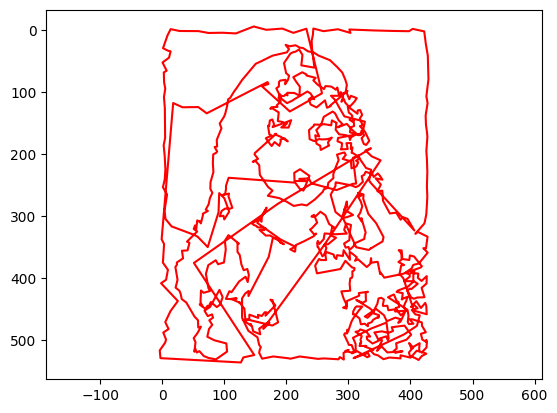

In [30]:


def fourier_approximate(smooth_curve, n_frequencies=100000):


    """
    Function 4: Approximate smooth curve using Fourier series
    
    Returns:
        frequencies: Integer frequencies for epicycles
        magnitude: Circle radii (amplitudes)
        phases: Starting angles
    """
    # Create complex signal
    z = smooth_curve[:,0] + 1j * smooth_curve[:,1]
    N = len(z)
    
    # Compute FFT and frequencies
    coefficients = np.fft.fft(z , norm='forward')
    frequencies = np.fft.fftfreq(N, 1/N)  # integer frequencies
    
    # Keep n largest components
    indices = np.argsort(-np.abs(coefficients))[:n_frequencies]
    frequencies = frequencies[indices]
    coefficients = coefficients[indices]
    
    # Get amplitudes and phases
    magnitude = np.abs(coefficients)
    phases = np.angle(coefficients)
    
    return frequencies, magnitude, phases

frequencies, magnitude, phases = fourier_approximate(smooth_curve, n_frequencies=1000)
print(frequencies[-10:], magnitude[-10:], phases[-10:])
print(frequencies.shape, magnitude.shape, phases.shape)


N = 1000
t_values = np.linspace(0, 1, N)  # Normalized time from 0 to 1

path = []
for t in t_values:
    z = 0
    for freq, amp, phase in zip(frequencies, magnitude, phases):
        z += amp * np.exp(1j * (2 * np.pi * freq * t + phase))
    path.append(z)
path = np.array(path)


x = path.real
y = path.imag

import matplotlib.pyplot as plt

plt.plot(x, y, 'r-')
plt.gca().invert_yaxis()  # Flip vertically

plt.axis('equal')
plt.show()

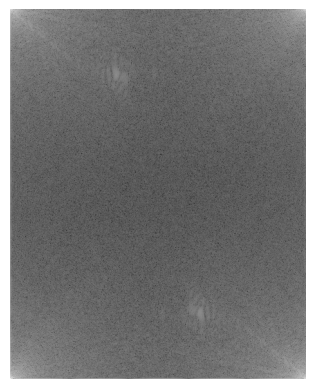

In [27]:
image = np.fft.fft2(image)
image = np.log(np.abs(image))
plt.imshow(image, cmap='gray')
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [28]:
image_freq = np.fft.fftfreq(900000)
print(image_freq)


[ 0.00000000e+00  1.11111111e-06  2.22222222e-06 ... -3.33333333e-06
 -2.22222222e-06 -1.11111111e-06]


200000


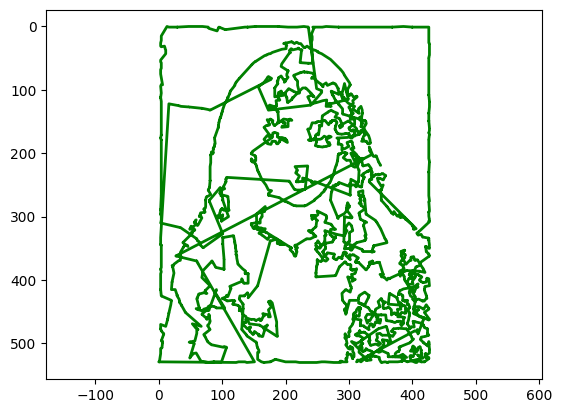

In [29]:
import bezier
import numpy as np

def create_piecewise_bezier(ordered_points, segment_size=10, n_eval=100):
    """
    Fit piecewise Bezier curves through ordered points.
    Each segment uses `segment_size` consecutive points.
    Returns:
        all_curve_points: concatenated array of all curve points
    """
    all_curve_points = []
    num_points = len(ordered_points)
    for start in range(0, num_points - segment_size // 2, segment_size):
        segment = ordered_points[start:start+segment_size]
        nodes = segment.T
        degree = nodes.shape[1] - 1
        curve = bezier.Curve(nodes, degree=degree)
        s_vals = np.linspace(0.0, 1.0, n_eval)
        curve_points = curve.evaluate_multi(s_vals).T
        all_curve_points.append(curve_points)
    # Concatenate all segments
    all_curve_points = np.vstack(all_curve_points)
    return all_curve_points

# Example usage:
smooth_curve = create_piecewise_bezier(ordered_points, segment_size=1, n_eval=100)
print(len(smooth_curve))
plt.plot(smooth_curve[:, 0], smooth_curve[:, 1], 'g-', linewidth=2)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()